# Quality analysis of crystallographic structures in the PDB

The following notebook presents the reproducible code for analyzing the quality of crystallographic structures in Protein Data Bank (PDB). The code contains comments concerning each step of the analysis, and can be considered a supplemental material for the paper *On the evolution of the quality of crystallographic models in the PDB* by Brzezinski *et al.*

The analysis was coded with Python 3.7.3 using the modules listed below. The full environment specification including module versions is provided in the `requirements.txt` in the root of the GitHub repository (https://github.com/dabrze/pdb_structure_quality).

In [3]:
# data wrangling and machine learning
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_palette("deep")
from plotnine import *
import plotnine.options
plotnine.options.figure_size = (10, 5)

# utils
import itertools
import warnings
from IPython.display import display

## Inital data cleaning

The data for this analysis was taken from the PDB as of 24 September 2018. Three files containing raw PDB metadata can be found in the `data` folder:

- `pdb_quality.fwf` contains information (fixed-width format) about:
    - the PDB code, 
    - structure resolution, 
    - date of deposition
    - R free,
    - clashscore
    - Ramachandran outliers
    - Rotamer outliers, 
    - RSR Z-score;
- `pdb_r.fwf` is a supplemental file containing information about the R-factor and contains the following columns:
    - PDB code, 
    - resolution, 
    - R-factor
    - R free;
- `pdb_journals.fwf` contains information about publications connected with PDB deposits, with columns representing:
    - the PDB code,
    - journal ISSN (or e-ISSN), 
    - journal name, 
    - journal volume
    - article page numbers,
    - publication year.
    
The following code reads the three above-mentioned dataset into pandas dataframes. For comparison purposes, the list of unique journal names prior to any normalization will be saved to `unique_journals_before.csv` in the `results` folder.

In [18]:
quality_df_raw = pd.read_fwf("data/pdb_quality.fwf",
                             names=["PDB code", "Resolution", "Date", 
                                    "Rfree_percentile_abs", "Clash_percentile_abs", "Ramachandran_percentile_abs", "Rota_percentile_abs", "RSRZ_percentile_abs", 
                                    "Rfree_percentile_rel", "Clash_percentile_rel", "Ramachandran_percentile_rel", "Rota_percentile_rel", "RSRZ_percentile_rel", 
                                    "R free", "Clashscore", "Ramachandran outliers", "Rotamer outliers", "RSR Z-score"],
                             na_values="NotAv")

journal_df_raw = pd.read_fwf("data/pdb_journals.fwf",
                             names=["PDB code", "ISSN", "Journal",
                                    "Volume", "Page", "Publication year"],
                             widths=[4, 22, 30, 6, 6, 5])

rfactors_df_raw = pd.read_fwf("data/pdb_r.fwf", index_col=0,
                              names=["PDB code", "Resolution", "R", "R free"],
                              widths=[4, 11, 10, 6],
                              na_values="NULL")

pd.DataFrame(journal_df_raw.Journal.unique(), columns=["Journal"]).sort_values("Journal").to_csv("results/unique_journals_before.csv", index=False)

Prior to any analysis, the data needs to be preprocessed. We will remove duplicates and non X-ray structures, combine information about R-factor with the remaining quality metrics, and perform preliminary journal name unification by removing punctuation from journal names. The following code performs the described tasks.

In [19]:
def unify_names_based_on_issn(df):
    journal_catalog = {}
    grouped_df = df.groupby(["ISSN", "Journal"])

    for name, group in grouped_df:
        issn = name[0]
        journal_name = name[1]

        if issn not in journal_catalog:
            journal_catalog[issn] = journal_name
        else:
            df.loc[df.loc[:, "ISSN"] == issn, "Journal"] = journal_catalog[issn]


def clean_quality_data(df, rfactors_df):
    cleaned_df = df.copy()
    print("---------------------------")
    print("PDB structure quality dataset")
    print("---------------------------")
    print("Initial number of structures: %d" % cleaned_df.shape[0])

    print("Found %d duplicates" % np.sum(cleaned_df.duplicated()))
    cleaned_df = cleaned_df.drop_duplicates()
    cleaned_df = cleaned_df.set_index("PDB code")

    print("Removed %d non X-ray structures" % np.sum(cleaned_df.Resolution.isna()))
    cleaned_df = cleaned_df.dropna(subset=["Resolution"])

    cleaned_df.loc[:, "Year"] = cleaned_df.loc[:, "Date"].apply(str).str.slice(stop=4).apply(int)
    cleaned_df.loc[:, "Date"] = pd.to_datetime(cleaned_df.loc[:, "Date"], format="%Y%m%d", errors='ignore').dt.date
    cleaned_df = cleaned_df.loc[:, ["Resolution", "Date", "Year", "Clashscore",
                                    "Ramachandran outliers", "Rotamer outliers", "RSR Z-score"]]

    r_df = rfactors_df.copy()[~rfactors_df.index.duplicated(keep='first')].loc[:, ["R", "R free"]]
    cleaned_df = pd.merge(cleaned_df, r_df, left_index=True, right_index=True, how="left")

    print("Final number of structures: %d" % cleaned_df.shape[0])
    print("---------------------------")
    print("")

    return cleaned_df


def clean_journal_data(df, quality_df):
    cleaned_df = df.copy()
    print("---------------------------")
    print("Journal information dataset")
    print("---------------------------")
    print("Initial number of structures: %d" % cleaned_df.shape[0])

    print("Found %d duplicates" % np.sum(cleaned_df.duplicated()))
    cleaned_df = cleaned_df.drop_duplicates()
    cleaned_df = cleaned_df.set_index("PDB code")

    cleaned_df.loc[:, "ISSN"] = cleaned_df.loc[:, "ISSN"].str.slice(start=-9)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace(".", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace(",", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace("   ", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.replace("  ", " ", regex=False)
    cleaned_df.loc[:, "Journal"] = cleaned_df.loc[:, "Journal"].str.strip()
    unify_names_based_on_issn(cleaned_df)

    print("Final number of structures: %d" % cleaned_df.shape[0])
    print("---------------------------")
    print("")

    return cleaned_df

def describe(df, rows=5):
    display(df.head(rows).style.hide_index())
    print("Dataset rows: {}".format(df.shape[0]))
    print("Dataset columns: {}".format(df.shape[1]))

In [20]:
quality_df = clean_quality_data(quality_df_raw, rfactors_df_raw)
journal_df = clean_journal_data(journal_df_raw, quality_df)

raw_journal_count = len(journal_df_raw.loc[:, "Journal"].unique())
issn_and_name_unification_journal_count = len(journal_df.loc[:, "Journal"].unique())

---------------------------
PDB structure quality dataset
---------------------------
Initial number of structures: 143621
Found 0 duplicates
Removed 12427 non X-ray structures
Final number of structures: 131194
---------------------------

---------------------------
Journal information dataset
---------------------------
Initial number of structures: 126764
Found 25 duplicates
Final number of structures: 126739
---------------------------



The provided data describes over **{{quality_df.shape[0]}} PDB deposits** by their PDB code, resolution, deposition date, several quality metrics, either as percentiles or raw values. The attached journal data describes **{{journal_df.shape[0]}} deposits** and **initially contained {{raw_journal_count}} journal names**. After correcting punctuation and whitespace errors, and name unification using ISSNs, the number of unique journal names **went down to {{issn_and_name_unification_journal_count}}**.

The first rows of dataframes containing information about structure quality and journal publications are presented below.

In [21]:
describe(quality_df)
describe(journal_df)

Resolution,Date,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free
1.9,1994-12-05,1994,4.46,nan,nan,0,0.145,nan
2.25,1994-12-14,1994,17.22,nan,nan,nan,0.163,0.252
2.07,1997-12-13,1997,16.75,0,3.17,0.65,0.157,0.202
2.2,1994-12-15,1994,2.49,nan,nan,0,0.155,nan
1.74,1992-09-29,1992,6.44,0,4.44,1.84,0.174,nan


Dataset rows: 131194
Dataset columns: 9


ISSN,Journal,Volume,Page,Publication year
0001-4842,ACC CHEM RES,V. 40,554,2007
2155-5435,ACS CATAL,nan,nan,2011
2155-5435,ACS CATAL,V. 3,2376,2013
2155-5435,ACS CATAL,V. 5,150,2015
2155-5435,ACS CATAL,V. 3,2376,2013


Dataset rows: 126739
Dataset columns: 5


## Journal name unification

Even after removing punctuation, several journal names have more than one name in the PDB metadata. The main causes of this situation are:

- there is more than one way of abbreviating a journal name (e.g., CHEM BIO CHEM vs CHEMBIOCHEM),
- the journal changed its name over time (e.g., EUR J BIOCHEM vs FEBS J).

To deal with this situation we used the levenstein distance to look for pairs of journal names that differ by 4 or less edits. This way we inspected journal names with potential typos or ambiguous abbreviations. To find journals that changed their name, we looked for journals with several structures published, that stopped publishing for at least two years having at least five distinct years with published structures.

The code below performs the analysis. The journal name pairs with levenstein distance 4 or less was saved to `levelstein.csv` and the list of of "disappearing" journals to `disappearing.csv`. The journal name mapping that resulted from manual inspection of these lists was saved to `journal_mapping.csv`. Finally, the list of unique journal names after the entire process of name unification can be found in the `unique_journals_after.csv` file.

In [23]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]


def create_levenstein_journal_list(journal_df):
    unique_journal_names = journal_df.loc[:, "Journal"].unique()
    pairs_df = pd.DataFrame(itertools.combinations(unique_journal_names, 2), columns=['J1', 'J2'])
    pairs_df.loc[:, "L"] = 0
    pairs_df.loc[:, "L"] = pairs_df.apply(lambda x: levenshtein(x.J1, x.J2), axis=1)
    
    return pairs_df

def create_disappearing_journal_list(journal_df, min_years_ago=2, min_year_count=5):
    grouped_df = journal_df.groupby(["Journal", "Publication year"])
    unique_journals = journal_df.loc[:, ["Journal", "ISSN"]].drop_duplicates(subset=["Journal"])
    
    journals = []
    min_years = []
    max_years = []
    counts = []

    for name, group in grouped_df:
        journal_name = name[0]
        year = name[1]

        if journal_name not in journals:
            journals.append(journal_name)
            min_years.append(year)
            max_years.append(year)
            counts.append(1)
        else:
            if year > max_years[-1]:
                max_years[-1] = year
           
            if year < min_years[-1]:
                min_years[-1] = year
                
            counts[-1] = counts[-1] + 1


    disappearing_df = pd.DataFrame({"Journal": journals, "Min": min_years, "Max": max_years, "Count": counts})
    disappearing_df.loc[:, "YearsAgo"] = 2018 - disappearing_df.Max

    
    
    disappearing_df = disappearing_df.loc[(disappearing_df.YearsAgo >= min_years_ago) & (disappearing_df.Count >= min_year_count), :]
    disappearing_df = pd.merge(disappearing_df, unique_journals, on="Journal", how="left")
    return disappearing_df.sort_values("Count", ascending=False)

In [24]:
max_levenstein_distance = 4

levenstein_journals_df = create_levenstein_journal_list(journal_df)
levenstein_journals_df.loc[levenstein_journals_df.L <= max_levenstein_distance, :].to_csv("results/levelstein.csv")

disappearing_journals_df = create_disappearing_journal_list(journal_df)
disappearing_journals_df.to_csv("results/disappearing.csv")

In [25]:
mapping_df = pd.read_csv("results/journal_mapping.csv", index_col=False)
mapping_dict = mapping_df.set_index('From')["To"].to_dict()
journal_df = journal_df.replace(mapping_dict)
unique_journals_df = pd.DataFrame(journal_df.Journal.unique(), columns=["Journal"]).sort_values("Journal")
unique_journals_df.to_csv("results/unique_journals_after.csv", index=False)

The entire process of data cleaning (disappearing journals, levenstein distance, manual inspection) resulted in **{{unique_journals_df.shape[0]}} unique journal names** describing {{journal_df.shape[0]}} structures. 

## Missing data imputation

In [93]:
quality_column_nan_ratios = quality_df.isna().sum() / quality_df.shape[0]
print(quality_column_nan_ratios)

quality_not_nan_filter = quality_df.index.isin(quality_df.dropna().index)
quality_not_nan_df = quality_df[quality_not_nan_filter]
quality_nan_df = quality_df[~quality_not_nan_filter]
quality_not_nan_ratio = quality_not_nan_df.shape[0] / quality_df.shape[0]
quality_nan_ratio = 1 - quality_not_nan_ratio

quality_nan_ratio

Resolution               0.000000
Date                     0.000000
Year                     0.000000
Clashscore               0.000968
Ramachandran outliers    0.018949
Rotamer outliers         0.020283
RSR Z-score              0.118268
R                        0.021220
R free                   0.063097
dtype: float64


0.14653871366068572

In [95]:
def introduce_random_nans(df, total_nan_pct, column_nan_pct, seed):
    naned_df = df.drop("Date", axis=1).copy()
    potential_nan_idxs = naned_df.sample(frac=total_nan_pct, random_state=seed).index
    i = seed

    for col in naned_df:
        col_frac = column_nan_pct[col] / total_nan_pct
        vals_to_nan = naned_df.loc[potential_nan_idxs, col].sample(frac=col_frac, random_state=i).index
        naned_df.loc[vals_to_nan, col] = np.NaN
        i = i + 1

    return naned_df

results_df = pd.DataFrame()

for i in range(100):
    test_df = introduce_random_nans(quality_not_nan_df, quality_nan_ratio, quality_column_nan_ratios, seed=i)
    test_idx = test_df.isna()
 
    for name, imputer in [
        ("Mean", SimpleImputer(strategy="mean")),
        ("Median", SimpleImputer(strategy="median")),
        ("Bayesian", IterativeImputer(random_state=23, max_iter=10))
    ]:       
        df_imputed = pd.DataFrame(imputer.fit_transform(test_df), columns=test_df.columns, index=test_df.index)
                    
        for col in test_df:
            if test_df[col].isna().any():
                for measure, func in [("MSE", mean_squared_error), 
                                      ("MAE", mean_absolute_error),
                                      ("MAD", median_absolute_error)]:
                    y_true = quality_not_nan_df.loc[test_idx[col], col]
                    y_pred = df_imputed.loc[test_idx[col], col]
        
                    results_df = results_df.append(pd.DataFrame({"Experiment": [i], "Method": [name], "Column": [col],
                                                                 "Measure": [measure], "Value": [func(y_true, y_pred)]}))

results_df.to_csv("imputer_evaluation_results.csv", index=False)

In [96]:
results_df = pd.read_csv("imputer_evaluation_results.csv")
results_df.loc[results_df.Measure == "MSE", "Value"] = np.sqrt(results_df.loc[results_df.Measure == "MSE", "Value"])
results_df.loc[results_df.Measure == "MSE", "Measure"] = "RMSE"


print(quality_not_nan_df.std())
results_df.pivot_table(index=["Measure", "Method"], columns="Column", values="Value")


Resolution               0.555617
Year                     4.878950
Clashscore               9.277621
Ramachandran outliers    1.243042
Rotamer outliers         3.716398
RSR Z-score              4.069144
R                        0.032640
R free                   0.038430
dtype: float64


Column            Clashscore         R    R free  RSR Z-score  \
Measure Method                                                  
MAD     Bayesian    2.549725  0.010757  0.010096     1.996114   
        Mean        4.626188  0.020268  0.025114     2.289628   
        Median      3.065850  0.020167  0.025113     1.851550   
MAE     Bayesian    3.745758  0.014367  0.012998     2.537815   
        Mean        5.825512  0.025047  0.030183     2.736148   
        Median      5.292119  0.025032  0.030182     2.605251   
RMSE    Bayesian    5.728475  0.019495  0.017522     3.870311   
        Mean        8.892679  0.032601  0.038436     4.080142   
        Median      9.270092  0.032623  0.038436     4.208407   

Column            Ramachandran outliers  Rotamer outliers  
Measure Method                                             
MAD     Bayesian               0.258631          1.261295  
        Mean                   0.507643          2.182889  
        Median                 0.076900          1.459500  
MAE     Bayesian               0.452002          1.812371  
        Mean                   0.620636          2.606232  
        Median                 0.507098          2.397898  
RMSE    Bayesian               0.852585          2.683230  
        Mean                   1.237935          3.689364  
        Median                 1.311156          3.885990

In [97]:
best_imputer = IterativeImputer(random_state=23, max_iter=10)
tmp_df = quality_df.drop("Date", axis=1)
quality_imputed_df = pd.DataFrame(best_imputer.fit_transform(tmp_df), columns=tmp_df.columns, index=quality_df.index)
quality_imputed_df.loc[:, "Date"] = quality_df.loc[:, "Date"]

In [98]:
quality_imputed_df.head()
print(quality_imputed_df.shape)

(131194, 9)


## PCA analysis

In this analysis we will focus on three raw quality metrics: **Clashscore**, **Ramachandran outliers** and **Rotamer outliers**.

In [99]:
pca_columns = ["Clashscore", "Ramachandran outliers", "Rotamer outliers"]
quality_df_filtered_columns = quality_df.loc[:, pca_columns]


The raw data are set on different scales and containg a couple of strong outliers (as can been seen on the plot below).

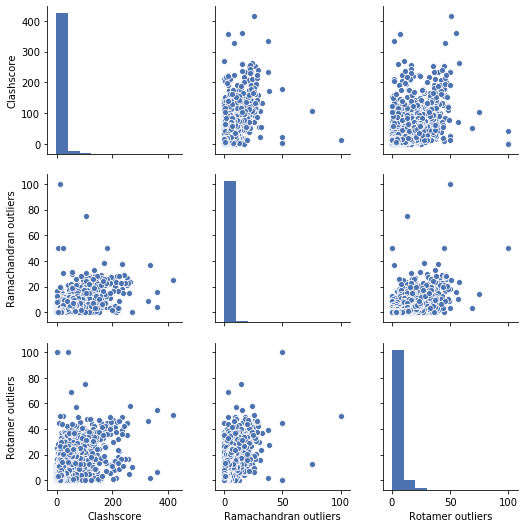

In [100]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.pairplot(quality_df_filtered_columns)

After removing strong outliers and standardizing the data (setting the mean to be 0 and standard deviation to 1), the data presents itself as follows.

In [101]:
df_filtered = quality_df_filtered_columns.drop(quality_df_filtered_columns[(quality_df_filtered_columns.loc[:, "Rotamer outliers"] > 50) | (quality_df_filtered_columns.loc[:, "Ramachandran outliers"] > 45) | (quality_df_filtered_columns.loc[:, "Clashscore"] > 250)].index, axis=0)

scaler = StandardScaler()
scaler.fit(df_filtered)
df_rescaled = scaler.transform(df_filtered)
df_rescaled = pd.DataFrame(df_rescaled, columns=pca_columns)
df_rescaled.head()

,Clashscore,Ramachandran outliers,Rotamer outliers
0,-0.420900,NaN,NaN
1,0.664400,NaN,NaN
2,0.624424,-0.413883,-0.144226
3,-0.588458,NaN,NaN
4,-0.252492,-0.413883,0.151996


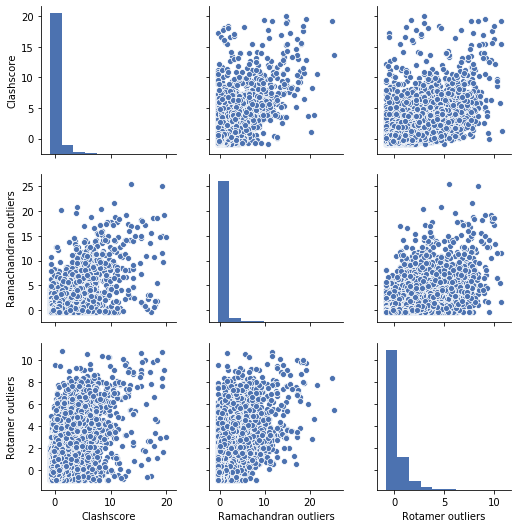

In [102]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.pairplot(df_rescaled)

In [103]:
pca = PCA(svd_solver="full")
pca.fit(df_rescaled.dropna())
principal_components =pca.transform(df_rescaled.dropna())
df_pca = pd.DataFrame(data = principal_components, columns = ['PC 1', 'PC 2', 'PC3'])
df_pca.head()

,PC 1,PC 2,PC3
0,0.048873,0.053758,0.762770
1,-0.298850,-0.403398,0.036942
2,-0.026481,-0.052937,-0.127501
3,0.604840,-0.291181,0.275189
4,-0.171990,-0.242313,0.296805


Runnign Principle Component Analysis on the standardized data results in three principle components PC 1, PC 2, PC 3, explaining 76%, 15%, 9% variance, respectively.

In [104]:
pca.explained_variance_ratio_

array([0.76592098, 0.1445763 , 0.08950272])

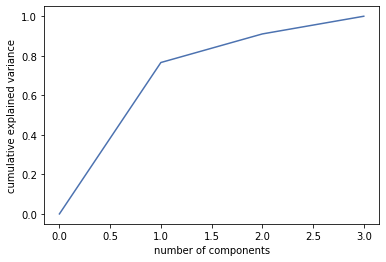

In [105]:
variance = np.array([0])
variance = np.append(variance, np.cumsum(pca.explained_variance_ratio_))
plt.plot(variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The eigenvectors of each pronciple component (presented below) show the linear combination coefficients of each quality measure.

In [106]:
df_eigen_vectors = pd.DataFrame(pca.components_,columns=df_rescaled.columns,index = ['PC 1','PC 2', 'PC 3'])
df_eigen_vectors

,Clashscore,Ramachandran outliers,Rotamer outliers
PC 1,0.586689,0.582150,0.562936
PC 2,0.247969,0.532610,-0.809220
PC 3,0.770913,-0.614351,-0.168121


The result obtained in this analysis (explained variance of each principle component, coefficients (eigenvecor) of the first pronciple component) are almost identical to those presented in "Multivariate Analyses of Quality Metrics for Crystal Structures in the PDB Archive" by Shao et al.

## Overall quality percentile rank computation (Q1)

In [115]:
def add_Q1(df, scale_transformer, pca_transformer):
    full_df = df.copy().dropna(subset=pca_columns)
    pca_df = pd.DataFrame(data=pca.transform(scaler.transform(full_df.loc[:, pca_columns])), 
                          columns=['PC1', 'PC2', 'PC3'],
                          index=full_df.index)
    
    pc1_p = pca_df.loc[:, "PC1"].rank(pct=True, ascending=False)
    rfree_p = full_df.loc[:, "R free"].rank(pct=True, ascending=False)
    zscore_p = full_df.loc[:, "RSR Z-score"].rank(pct=True, ascending=False)
    full_df.loc[:, "Q1"] = (pc1_p + rfree_p + zscore_p) / 3.0
    full_df.loc[:, "Q1 percentile"] = full_df.loc[:, "Q1"].rank(pct=True)
    
    return full_df
    
quality_q1_df = add_Q1(quality_df, scaler, pca)
quality_imputed_q1_df = add_Q1(quality_imputed_df, scaler, pca)

print(quality_q1_df.shape)
print(quality_imputed_q1_df.shape)

(111969, 11)
(131194, 11)


## Preliminary data analysis

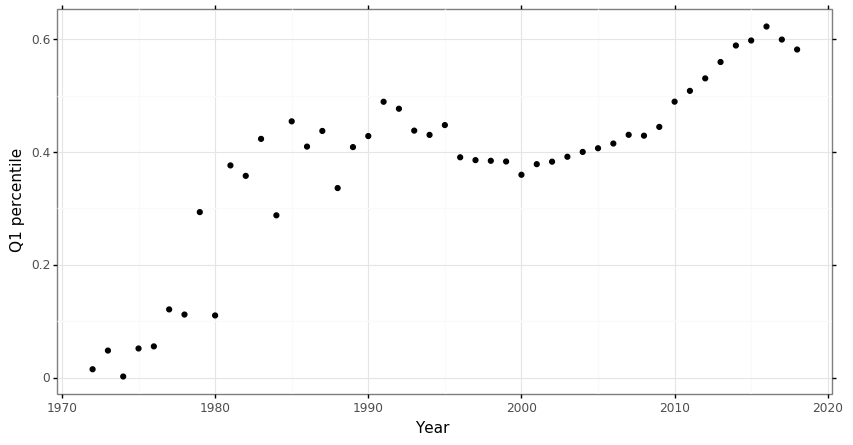

In [112]:
plot_df = quality_imputed_q1_df.copy()
plot_df.loc[:, "Resolution"] = plot_df.loc[:, "Resolution"].round(decimals=1)
year_df = plot_df.groupby(['Year'], as_index=False).mean()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (ggplot(year_df, aes(x="Year", y="Q1 percentile")) + geom_point() + theme_bw()).draw();

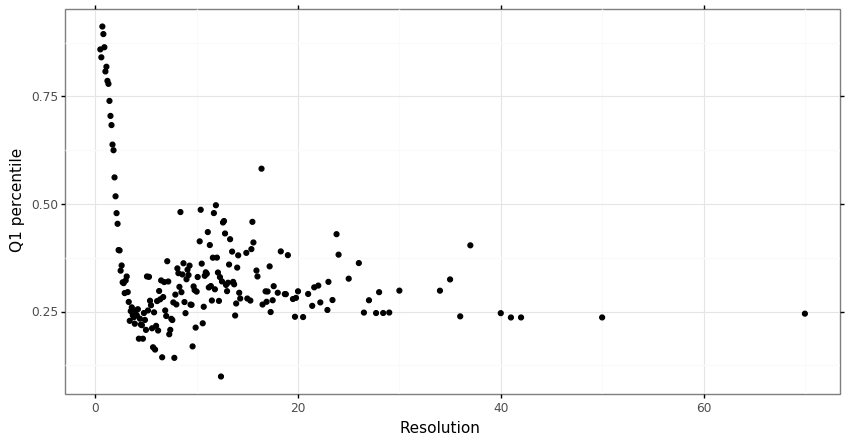

In [113]:
resolution_df = plot_df.groupby(['Resolution'], as_index=False).mean()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (ggplot(resolution_df, aes(x="Resolution", y="Q1 percentile")) + geom_point() + theme_bw()).draw();

It can be noticed that there is a general trend of Q1 improving over the years. This is connected with the improvement of data collection procedure, hardware, software, and structure refinement standards. If one were to use Q1 calculated over all the analyzed years to rank journals, then journals with a longer history would be handicapped because they contain old structures. Even though a structure might have been impressively refined in its time, now it might be treated as a poorly refined structure according to current standards. One could recalculate Q1 percentiles separately for each decade or smaller time periods, but might not be sufficient (see the rapid improvement in the last 10 years) or would drastically reduce the data volume and effectively make journal comparison impossible. Therefore we propose to calculate Q1(t) - the Q1  percentile calculated at time of structure deposition.

In [119]:
def add_Q1_t(df, scale_transformer, pca_transformer):
    full_df = df.sort_values(by=['Date']).dropna(subset=pca_columns).copy()
    pca_df = pd.DataFrame(data=pca.transform(scaler.transform(full_df.loc[:, pca_columns])), 
                          columns=['PC1', 'PC2', 'PC3'],
                          index=full_df.index)
    
    pc1_p = pca_df.loc[:, "PC1"].expanding().apply(lambda x: pd.Series(x).rank(pct=True, ascending=False).iloc[-1], raw=True)
    rfree_p = full_df.loc[:, "R free"].expanding().apply(lambda x: pd.Series(x).rank(pct=True, ascending=False).iloc[-1], raw=True)
    zscore_p = full_df.loc[:, "RSR Z-score"].expanding().apply(lambda x: pd.Series(x).rank(pct=True, ascending=False).iloc[-1], raw=True)
    full_df.loc[:, "Q1(t)"] = (pc1_p + rfree_p + zscore_p) / 3.0
    full_df.loc[:, "Q1(t) percentile"] = full_df.loc[:, "Q1(t)"].expanding().apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=True)
    
    return full_df

journal_quality_df = pd.merge(quality_df, journal_df, left_index=True, right_index=True)
print(journal_quality_df.shape)
journal_quality_imputed_df = pd.merge(quality_imputed_df, journal_df, left_index=True, right_index=True)
print(journal_quality_imputed_df.shape)

# journal_quality_q1_t_df = add_Q1_t(journal_quality_imputed_df, scaler, pca)
# journal_quality_imputed_q1_t_df.to_csv("quality_q1_t_df.csv")
# journal_quality_imputed_q1_t_df = add_Q1_t(journal_quality_imputed_df, scaler, pca)
# journal_quality_imputed_q1_t_df.to_csv("quality_imputed_q1_t_df.csv")
print(journal_quality_q1_t_df.shape)
print(journal_quality_imputed_q1_t_df.shape)
journal_quality_imputed_q1_t_df.head()

(126739, 14)
(126739, 14)
(126739, 16)
(126739, 16)


,Resolution,Year,Clashscore,Ramachandran outliers,Rotamer outliers,RSR Z-score,R,R free,Date,ISSN,Journal,Volume,Page,Publication year,Q1(t),Q1(t) percentile
PDB code,,,,,,,,,,,,,,,,
1sbt,2.5,1972.0,95.46,6.59,10.73,5.453971,0.251807,0.309342,1972-08-11,0006-291X,BIOCHEM BIOPHYS RES COMMUN,V. 45,337,1971.0,1.000000,1.000000
1mbn,2.0,1973.0,54.11,3.31,15.20,4.515475,0.214654,0.277364,1973-04-05,0079-6808,PROG STEREOCHEM,V. 4,299,1969.0,1.000000,0.750000
2dhb,2.8,1973.0,26.21,5.65,15.09,4.046463,0.229415,0.297561,1973-11-01,0028-0836,NATURE,V. 228,551,1970.0,0.888889,0.333333
3ldh,3.0,1974.0,189.70,14.60,39.86,8.368748,0.311512,0.394878,1974-06-06,0022-2836,J MOL BIOL,V. 102,759,1976.0,0.250000,0.250000
2cha,2.0,1975.0,23.29,1.73,16.67,3.769948,0.199410,0.265469,1975-01-01,0022-2836,J MOL BIOL,V. 68,187,1972.0,1.000000,0.800000


We remove the first 100 structures to to avoid random effects of unstable percentiles...

In [131]:
MIN_STRUCTURES_IN_JOURNAL = 100
PERCENTILE_OFFSET = 100

plot_df = journal_quality_imputed_q1_t_df.iloc[PERCENTILE_OFFSET:, :].copy()
venue_count_df = plot_df.groupby(['Journal'], as_index=False).size()
venue_count_df = venue_count_df.rename("Structure count")
popular_venues = venue_count_df[venue_count_df >= MIN_STRUCTURES_IN_JOURNAL].index
plot_df = plot_df.loc[plot_df.Journal.isin(popular_venues), :]

In [132]:
# TODO pomysł: wykres przez lata z przeplatającymi się liniami - rankingiem czasopism 
# bump chart: https://www.sharpsightlabs.com/blog/shipping-analysis-r-data-visualization/

### Top 10

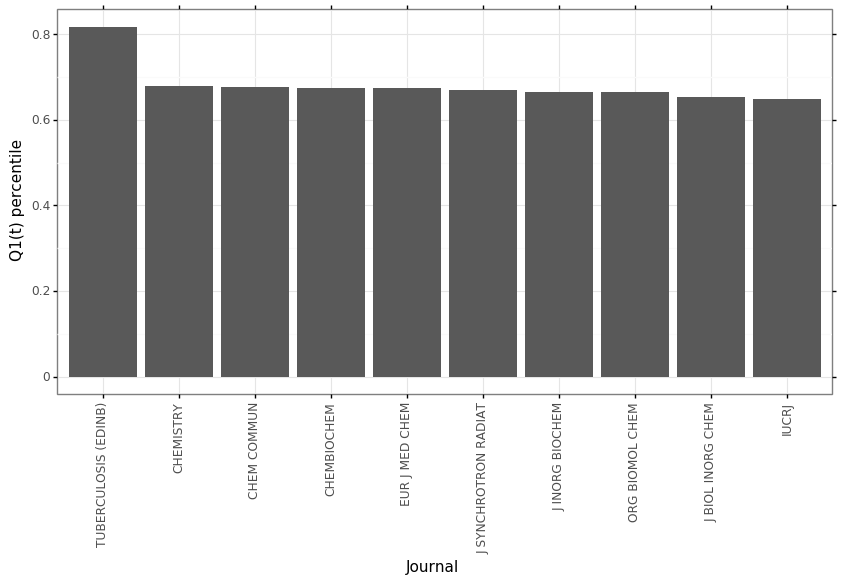

In [134]:
venue_df = plot_df.groupby(['Journal'], as_index=False).mean()
venue_df = pd.merge(venue_df, venue_count_df, right_index=True, left_on="Journal")

top_ten = venue_df.sort_values(by="Q1(t) percentile", ascending=False).head(10)
top_ten['Journal'] = pd.Categorical(top_ten['Journal'], categories=top_ten.Journal)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (ggplot(top_ten, aes(x="Journal", y="Q1(t) percentile")) + 
     geom_bar(stat="identity") + 
     theme_bw() + 
     theme(axis_text_x = element_text(angle = 90))
    ).draw();

### Bottom 10

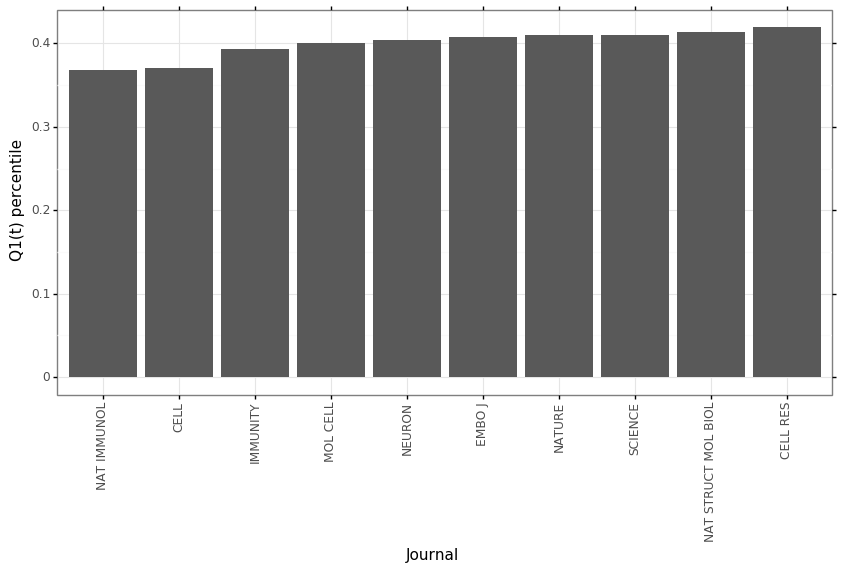

In [135]:
bottom_ten = venue_df.sort_values(by="Q1(t) percentile", ascending=True).head(10)
bottom_ten['Journal'] = pd.Categorical(bottom_ten['Journal'], categories=bottom_ten.Journal)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (ggplot(bottom_ten, aes(x="Journal", y="Q1(t) percentile")) + 
     geom_bar(stat="identity") + 
     theme_bw() +
     theme(axis_text_x = element_text(angle = 90))
    ).draw();

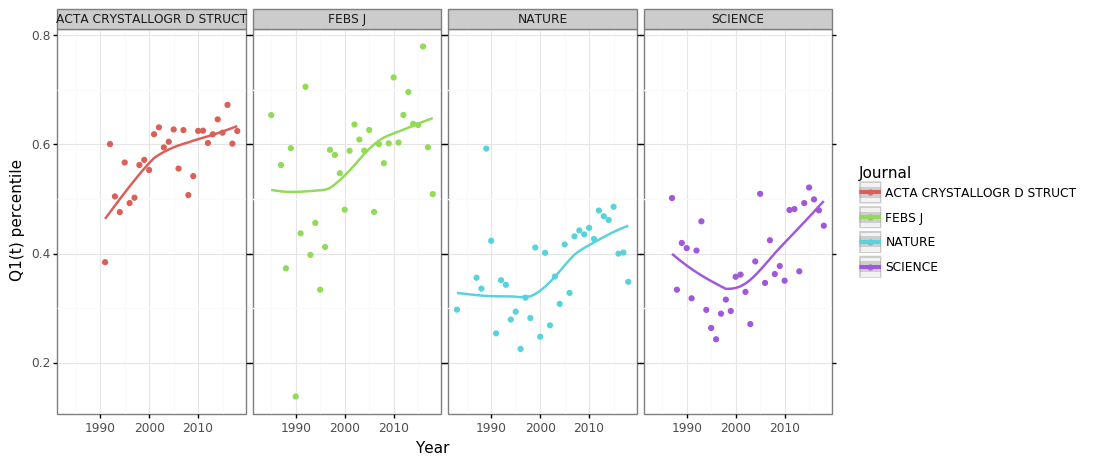

In [136]:
year_venue_df = plot_df.groupby(['Year', 'Journal'], as_index=False).mean()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (ggplot(year_venue_df.loc[year_venue_df.Journal.isin(['FEBS J', 'SCIENCE', 'NATURE', 'ACTA CRYSTALLOGR D STRUCT']), :], aes(x="Year", y="Q1(t) percentile", color="Journal")) + 
     geom_point() +
     facet_grid('.~Journal') + 
     geom_smooth() +
     theme_bw()
    ).draw();

### All-time (mean) ranking

In [137]:
ranking_df = venue_df.sort_values(by="Q1(t) percentile", ascending=False).loc[:, ["Journal", "Q1(t) percentile", "Structure count"]]
ranking_df.insert(loc=0, column='Rank', value=(np.arange(len(ranking_df)) + 1))
ranking_df = ranking_df.set_index('Rank')
ranking_df.to_csv("ranking.csv")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ranking_df)

,Journal,Q1(t) percentile,Structure count
Rank,,,
1,TUBERCULOSIS (EDINB),0.817739,132
2,CHEMISTRY,0.679935,189
3,CHEM COMMUN,0.675740,230
4,CHEMBIOCHEM,0.674635,478
5,EUR J MED CHEM,0.673878,288
6,J SYNCHROTRON RADIAT,0.668687,131
7,J INORG BIOCHEM,0.665807,146
8,ORG BIOMOL CHEM,0.665625,147
9,J BIOL INORG CHEM,0.652747,250


## Ranking over time

In [306]:
TOP_N = 25

COLORED_JOURNALS = ["CHEMBIOCHEM", "CHEM COMMUN", "CHEMISTRY", "J BIOL INORG CHEM", " CHEM SCI", "FEBS J"]

year_venue_df_over_time = plot_df.copy()
year_venue_df_over_time.loc[(year_venue_df_over_time.Year <= 1990), "Year"] = 1990
year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 1990) & (year_venue_df_over_time.Year <= 1995), "Year"] = 1995
year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 1995) & (year_venue_df_over_time.Year <= 2000), "Year"] = 2000
year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2000) & (year_venue_df_over_time.Year <= 2005), "Year"] = 2005
year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2005) & (year_venue_df_over_time.Year <= 2010), "Year"] = 2010
year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2010) & (year_venue_df_over_time.Year <= 2015), "Year"] = 2015
year_venue_df_over_time.loc[(year_venue_df_over_time.Year > 2015), "Year"] = 2020

year_venue_df_over_time = year_venue_df_over_time.groupby(['Year', 'Journal'], as_index=False).mean().copy()
year_venue_df_over_time.loc[:, "Rank"] = year_venue_df_over_time.groupby(['Year'])["Q1(t) percentile"].rank(ascending=False)
year_venue_df_over_time.loc[:, "Journal color"] = "zzz"
year_venue_df_over_time.loc[year_venue_df_over_time.Journal.isin(COLORED_JOURNALS), "Journal color"] = year_venue_df_over_time.loc[year_venue_df_over_time.Journal.isin(COLORED_JOURNALS), "Journal"] 

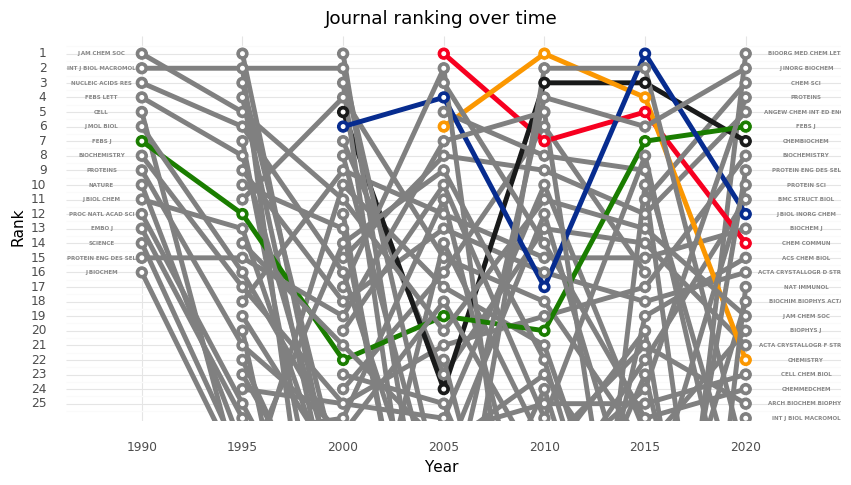

In [307]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (ggplot(year_venue_df_over_time, aes(x = "Year", y = "Rank", group = "Journal")) +
     geom_line(aes(color = "Journal color", alpha = 1), size = 2) +
     geom_point(aes(color = "Journal color", alpha = 1), size = 4) +
     geom_point(color = "#FFFFFF", size = 1) +
     scale_y_reverse(breaks = range(1, TOP_N + 1)) +
     scale_x_continuous(breaks = range(1990, 2025, 5), minor_breaks = range(1990, 2025, 5)) +
     geom_text(year_venue_df_over_time.loc[year_venue_df_over_time.Year == year_venue_df_over_time.Year.min(), :],
               aes(label = "Journal", x = year_venue_df_over_time.Year.min() - 2, hjust = .85), fontweight = "bold", color = "#888888", size = 4) +
     geom_text(year_venue_df_over_time.loc[year_venue_df_over_time.Year == year_venue_df_over_time.Year.max(), :],
               aes(label = "Journal", x = year_venue_df_over_time.Year.max() + 3, hjust = 0.15), fontweight = "bold", color = "#888888", size = 4) +
     coord_cartesian(ylim= (TOP_N, 1)) + 
     theme_minimal() + 
     theme(legend_position = "none") +
     labs(title = "Journal ranking over time",
       subtitle = "Journals ranked by average Q1(t) within each year") + 
       scale_color_manual(values = ["#F70020","#191A1A","#FB9701","#1A7D00","#072C8F", "grey"])
    ).draw();